In [14]:
## Standard imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from quantimpy import morphology as mp
from quantimpy import minkowski as mk
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 

In [15]:
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_ID_1 = 'DiscreteSBM_MultiSigmaVPSDE_I_BPROJ_N_4000_bottleneck_16_firstc_6'
MODEL_ID_2 = 'DiscreteSBM_MultiSigmaVPSDE_I_BPROJ_N_1000_bottleneck_16_firstc_6'

In [35]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())

diffuser_1 = Diffuser(placeholder_dm)
diffuser_1.load(config=config_from_id(MODEL_ID_1), also_ckpt=True, for_training=True)

diffuser_2 = Diffuser(placeholder_dm)
diffuser_2.load(config=config_from_id(MODEL_ID_2), also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.


Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.
No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


In [36]:
theta_mean = diffuser_1.diffmodel.ps.sample_theta(10000).mean(dim=0, keepdim=True).to(device)
theta_mean

tensor([[6.9991e+01, 3.1867e-02]], device='cuda:0')

In [37]:
sample = diffuser_1.test_dataloader.dataset[0].unsqueeze(0).unsqueeze(1).to(device)
sample.shape

torch.Size([1, 1, 256, 256])

### Latent codes

In [38]:
gen1 = diffuser_1.diffmodel.forward_ode_sampling(sample, thetas= theta_mean)

100%|██████████| 4000/4000 [00:23<00:00, 167.20it/s]


In [39]:
gen2 = diffuser_2.diffmodel.forward_ode_sampling(sample, thetas= theta_mean)

100%|██████████| 1000/1000 [00:05<00:00, 167.23it/s]


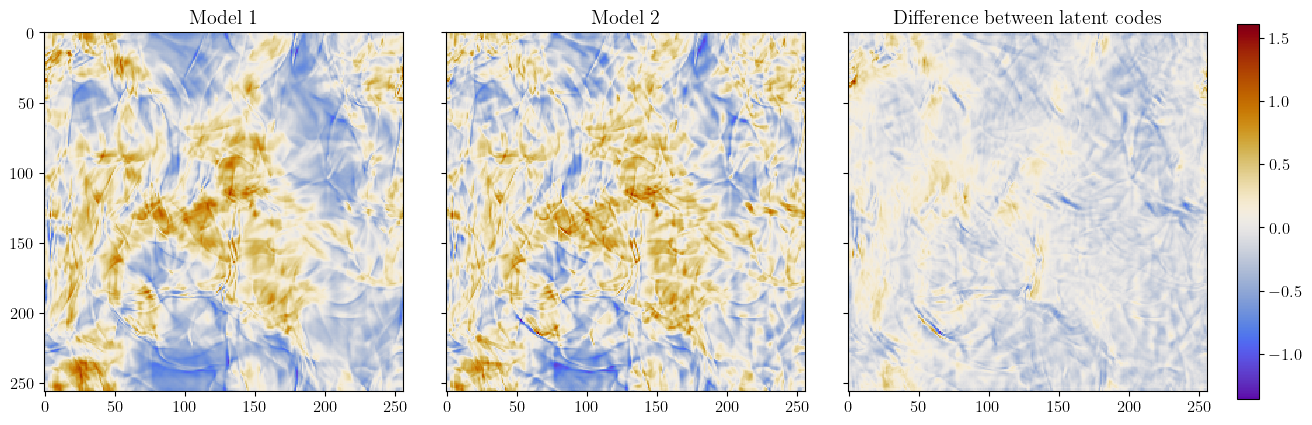

In [40]:
latent_code_1 = gen1[0,0].detach().cpu().numpy()
latent_code_2 = gen2[0,0].detach().cpu().numpy()

vmin = min(latent_code_1.min(), latent_code_2.min())
vmax = max(latent_code_1.max(), latent_code_2.max())

fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
im_1 = ax[0].imshow(latent_code_1, cmap = 'cmb', vmin=vmin, vmax=vmax)
ax[0].set_title('Model 1')
im_2 = ax[1].imshow(latent_code_2, cmap = 'cmb', vmin=vmin, vmax=vmax)
ax[1].set_title('Model 2')
im_3 = ax[2].imshow(latent_code_1 - latent_code_2, cmap = 'cmb', vmin=vmin, vmax=vmax)
ax[2].set_title('Difference between latent codes')
fig.colorbar(im_1, cax=fig.add_axes([0.92, 0.12, 0.015, 0.75])) # left, bottom, width, height
plt.subplots_adjust(wspace=0.12, hspace=0.05)
if save_fig:
    fig.savefig('figs/latent_codes.pdf', bbox_inches='tight')

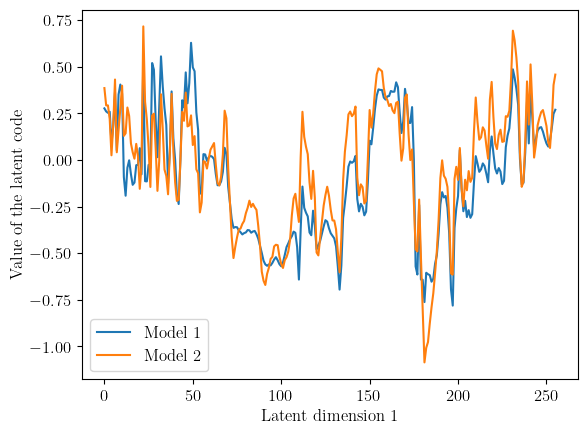

In [41]:
plt.plot(latent_code_1[10], label='Model 1')
plt.plot(latent_code_2[10], label='Model 2')
plt.legend()
plt.xlabel('Latent dimension 1')
plt.ylabel('Value of the latent code')
if save_fig:
    plt.savefig('figs/latent_code_dimension_1.pdf', bbox_inches='tight')

### ODE sampling summary statistics

In [24]:
num_samples = 128

In [25]:
samples_ode = diffuser_1.diffmodel.ode_sampling(num_samples)

  0%|          | 0/4000 [00:00<?, ?it/s]

  8%|▊         | 329/4000 [00:16<03:04, 19.93it/s]

KeyboardInterrupt: 

  8%|▊         | 329/4000 [00:27<03:04, 19.93it/s]

In [ ]:
samples_ode_theta_mean = diffuser_1.diffmodel.ode_sampling(num_samples, thetas= theta_mean.repeat(num_samples,1))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:55<00:00, 18.07it/s]


In [ ]:
samples_sde = diffuser_1.diffmodel.generate_image(num_samples)

  0%|          | 3/1000 [00:00<00:38, 25.72it/s]

100%|██████████| 1000/1000 [00:56<00:00, 17.69it/s]


In [ ]:
samples_sde_theta_mean = diffuser_1.diffmodel.generate_image(num_samples, thetas= theta_mean.repeat(num_samples,1))

  0%|          | 3/1000 [00:00<00:38, 25.98it/s]

100%|██████████| 1000/1000 [00:56<00:00, 17.67it/s]


In [ ]:
##
## COMPUTTATION OF THE POWER SPECTRUM
##

max_num_samples = 128

## Get results from the sample_dir corresponding to the diffuser

dataset = diffuser_1.train_dataloader.dataset
shape = dataset[0].shape
if len(shape) == 3:
    datapoints = torch.cat([dataset[i].reshape(1,-1,shape[1], shape[2]) for i in range(min(len(dataset), max_num_samples))]).to(device)
elif len(shape) == 2:
    datapoints = torch.cat([dataset[i].reshape(1,1,shape[0], shape[1]) for i in range(min(len(dataset), max_num_samples))]).to(device)
else:
    datapoints = torch.cat([dataset[i] for i in range(min(len(dataset), max_num_samples))]).to(device)

## Compute power spectrum
bins = torch.linspace(0, np.pi, 100).to(device)

bins_centers = (bins[:-1] + bins[1:])/2
bins_centers = bins_centers.cpu()
mean_list = []
std_list = []
for data in [datapoints, samples_ode, samples_ode_theta_mean, samples_sde, samples_sde_theta_mean]:
    mean_, std_ , bins = powerSpectrum.set_power_spectrum_iso2d(data.to(device), bins, use_gpu=True)
    mean_list.append(mean_)
    std_list.append(std_)

mean_list = [mean.cpu().numpy() for mean in mean_list]
std_list = [std.cpu().numpy() for std in std_list]

In [ ]:
ps_bins = bins_centers.cpu()
ps_mean_list = [mean[:-1] for mean in mean_list]
ps_std_list = [std[:-1] for std in std_list]

In [ ]:
l_samples_ode = np.split(samples_ode, len(samples_ode), axis=0)
l_samples_ode = [l_samples_ode[i][0][0].cpu().numpy() for i in range(len(l_samples_ode))]

l_samples_ode_theta_mean = np.split(samples_ode_theta_mean, len(samples_ode_theta_mean), axis=0)
l_samples_ode_theta_mean = [l_samples_ode_theta_mean[i][0][0].cpu().numpy() for i in range(len(l_samples_ode_theta_mean))]

l_samples_sde = np.split(samples_sde, len(samples_sde), axis=0)
l_samples_sde = [l_samples_sde[i][0][0].cpu().numpy() for i in range(len(l_samples_sde))]

l_samples_sde_theta_mean = np.split(samples_sde_theta_mean, len(samples_sde_theta_mean), axis=0)
l_samples_sde_theta_mean = [l_samples_sde_theta_mean[i][0][0].cpu().numpy() for i in range(len(l_samples_sde_theta_mean))]

dataset = diffuser_1.train_dataloader.dataset

num_dataset_samples = 128

l_dataset = [dataset[i].numpy().copy(order = 'C') for i in range(num_dataset_samples)]

range_min = -3

range_max = 6

gs_vals = np.linspace(range_min, range_max, 200)

sampwise_minkmean  = []
sampwise_minkstd = []
for samp in [l_dataset,l_samples_ode, l_samples_ode_theta_mean, l_samples_sde, l_samples_sde_theta_mean]:
    samp_minks = []
    for isa in range(len(samp)):#each image
        image = samp[isa]
        gs_masks = [image>=gs_vals[ig] for ig in range(len(gs_vals))]
        minkowski = []
        for i in range(len(gs_masks)):
            minkowski.append(mk.functionals(gs_masks[i], norm=True))
        minkowski = np.vstack(minkowski) #N_alphax3
        samp_minks.append(minkowski)
    samp_minks = np.stack(samp_minks) #NsampxN_alphax3
    sampwise_minkmean.append(samp_minks.mean(0))
    sampwise_minkstd.append(np.std(samp_minks, axis=0, ddof=1))

In [ ]:
mink_x = gs_vals

In [ ]:
save_fig = False

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

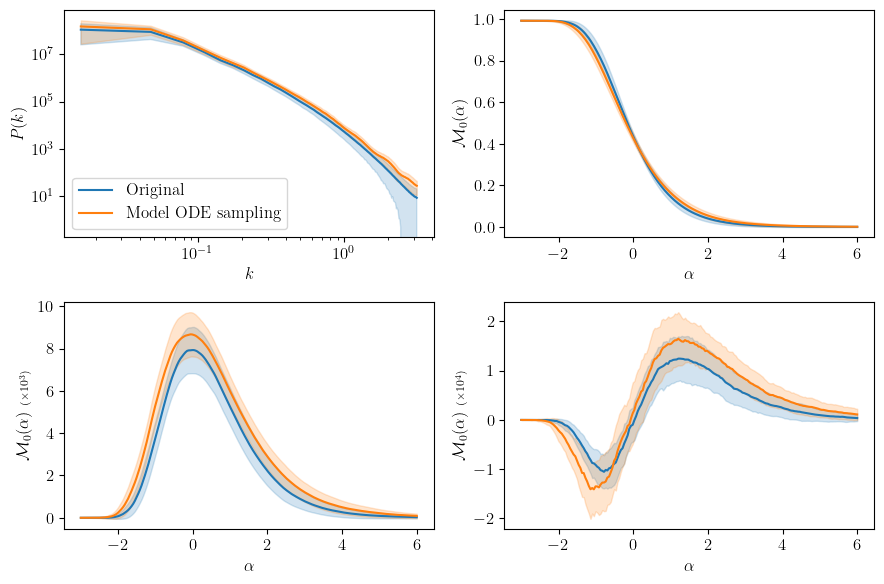

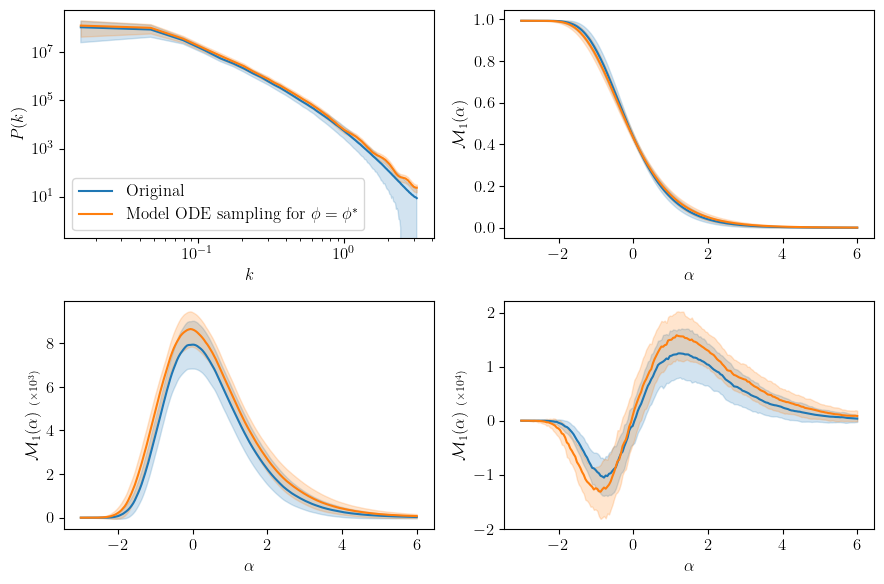

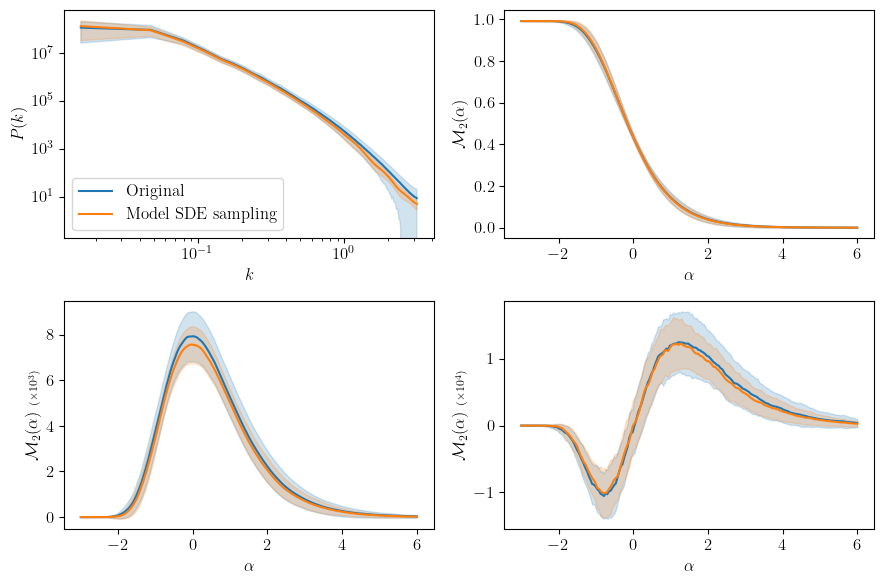

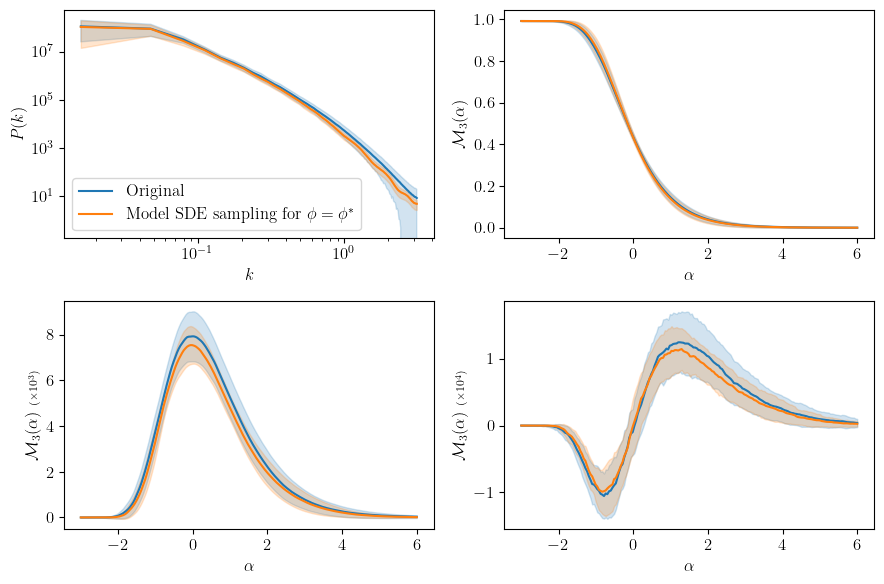

In [ ]:
for i in range(4):
    fig, axs = plt.subplots(2, 2, figsize=(9, 6))

    labels = ['Original', 'Model ODE sampling', 'Model ODE sampling for $\phi = \phi^*$', 'Model SDE sampling', 'Model SDE sampling for $\phi = \phi^*$']

    axs[0,0].plot(ps_bins, ps_mean_list[0], label=labels[0], color='C0')
    axs[0,0].fill_between(ps_bins, ps_mean_list[0]-ps_std_list[0], ps_mean_list[0]+ps_std_list[0], alpha=0.2, color='C0')
    axs[0,0].plot(ps_bins, ps_mean_list[i+1], label= labels[i+1], color='C1')
    axs[0,0].fill_between(ps_bins, ps_mean_list[i+1]-ps_std_list[i+1], ps_mean_list[i+1]+ps_std_list[i+1], alpha=0.2, color='C1')

    axs[0,0].set_xlabel(r'$k$')
    axs[0,0].set_ylabel(r'$P(k)$')
    axs[0,0].set_xscale('log')
    axs[0,0].set_yscale('log')
    axs[0,0].legend()

    pow_factors = [None, 3, 4] # Renormalization of the Minkowski functionals for better visualization

    for j in range(3):
        row = (j + 1)//2
        col = (j + 1)%2

        fac = pow_factors[j]
        label_renorm = ''
        if fac is None:
            fac = 1
        else:
            fac = 10 ** fac
            label_renorm = f'  ${{\\scriptstyle (\\times 10^{{{pow_factors[j]}}})}}$'

        axs[row, col].plot(mink_x, sampwise_minkmean[0][:,j]*fac, color='C0')
        axs[row, col].fill_between(mink_x, (sampwise_minkmean[0][:,j]-sampwise_minkstd[0][:,j])*fac, (sampwise_minkmean[0][:,j]+sampwise_minkstd[0][:,j])*fac, alpha=0.2, color='C0')

        axs[row, col].plot(mink_x, sampwise_minkmean[i+1][:,j]*fac, color='C1')
        axs[row, col].fill_between(mink_x, (sampwise_minkmean[i+1][:,j]-sampwise_minkstd[i+1][:,j])*fac, (sampwise_minkmean[i+1][:,j]+sampwise_minkstd[i+1][:,j])*fac, alpha=0.2, color='C1')

        axs[row, col].set_xlabel(r'$\alpha$')
        axs[row, col].set_ylabel(f'$\\mathcal{{M}}_{i}(\\alpha)$' + label_renorm)

    plt.tight_layout()

    if save_fig:
        if i == 0:
            fig.savefig('figs/stats_variant_ode.pdf')
        elif i == 1:
            fig.savefig('figs/stats_variant_ode_mean.pdf')
        elif i == 2:
            fig.savefig('figs/stats_variant_sde.pdf')
        elif i == 3:
            fig.savefig('figs/stats_variant_sde_mean.pdf')
    plt.show()